In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
# mage_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# This line creates a dictionary called image_datasets that maps dataset names to their corresponding ImageFolder objects.
# The ImageFolder objects are created using the datasets.ImageFolder class from PyTorch.
# The os.path.join(data_dir, x) expression joins the data_dir path with the dataset name (x) to form the full path to the dataset directory.
# The data_transforms[x] expression applies a transformation to the data (e.g., resizing, normalization) based on the dataset name (x).
# 3. dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}
# This line creates a dictionary called dataloaders that maps dataset names to their corresponding DataLoader objects.
# The DataLoader objects are created using the torch.utils.data.DataLoader class from PyTorch.
# The DataLoader objects are used to load the data in batches during training.
# The batch_size=4 argument specifies the number of samples to include in each batch.
# The shuffle=True argument specifies that the data should be shuffled before loading.
# The num_workers=0 argument specifies the number of worker threads to use for loading the data.
# 4. dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# This line creates a dictionary called dataset_sizes that maps dataset names to their corresponding sizes.
# The len(image_datasets[x]) expression returns the number of samples in the dataset.
# 5. class_names = image_datasets['train'].classes
# This line retrieves the class names from the training dataset.
# The image_datasets['train'].classes expression returns a list of class names.

In [ ]:
# inp.numpy(): This method converts the TensorFlow tensor inp to a NumPy array.
# .transpose((1, 2, 0)): This method transposes the dimensions of the NumPy array.
# Transpose Explanation:
# The transpose operation rearranges the dimensions of the array. In this case, the dimensions are being rearranged from (0, 1, 2) to (1, 2, 0).
# Dimension Indexing:
# In TensorFlow and NumPy, dimensions are indexed starting from 0.
# 0 typically corresponds to the batch dimension (or sample dimension).
# 1 and 2 typically correspond to the spatial dimensions (height and width) of an image.

['ants', 'bees']


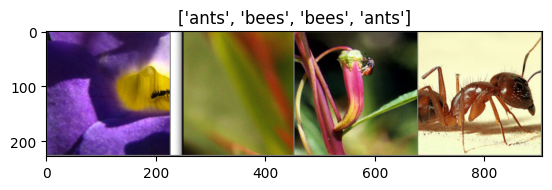

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)


def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    
    inp = std * inp + mean # reverse normalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


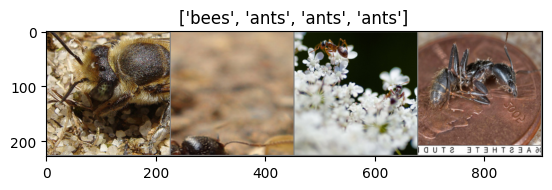

In [3]:


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# model: The PyTorch model to be trained.
# criterion: The loss function to be used for training.
# optimizer: The optimization algorithm to be used for training.
# scheduler: The learning rate scheduler to be used for training.
# num_epochs: The number of epochs to train the model for (default is 25).
# since: The current time, used to track the training time.
# best_model_wts: A deep copy of the model's initial weights, used to store the best weights found during training.
# best_acc: The best accuracy achieved during training, initialized to 0.0.


In [ ]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)
# These lines modify the pre-trained model to suit the binary classification task:
# num_ftrs = model.fc.in_features gets the number of input features to the final fully connected layer (fc) of the pre-trained model.
# model.fc = nn.Linear(num_ftrs, 2) replaces the final fully connected layer with a new one that has 2 output features (for binary classification).

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

In [4]:

#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

c:\Users\juwel\cuda_test\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\juwel\cuda_test\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\juwel/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Epoch 0/24
----------
train Loss: 0.6917 Acc: 0.5984
val Loss: 0.4624 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.5008 Acc: 0.7869
val Loss: 0.3267 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4480 Acc: 0.8320
val Loss: 0.2746 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4249 Acc: 0.8156
val Loss: 0.2604 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3830 Acc: 0.8320
val Loss: 0.2152 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4408 Acc: 0.7992
val Loss: 0.1957 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3744 Acc: 0.8402
val Loss: 0.1895 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3606 Acc: 0.8525
val Loss: 0.1947 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3846 Acc: 0.8320
val Loss: 0.1798 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3757 Acc: 0.8402
val Loss: 0.1874 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3364 Acc: 0.8525
val Loss: 0.1809 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3515 Acc: 0.8320
val Loss: 0.1895 Acc: 0.9412

Ep